In [1]:
working_dimers = ['CSD20', 'CSD23', 'CSD25', 'CSD26']

with open('../af2/good_models.list', 'r') as f:
    good_models = f.read().splitlines()

# working_models = [x for x in good_models if x.split('/')[-1][:5] in working_dimers]

working_models = []

for working_dimer in working_dimers:
    models_all = [x for x in good_models if x.split('/')[-1][:5] == working_dimer]
    models_A = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'A_')]
    models_B = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'B_')]
    models_AB = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'AB_')]

    working_models.append([models_A, models_B, models_AB, models_AB])

In [2]:
import pyrosetta
pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
}})

In [4]:
# make all combinations of backbones from different AF2 models for each SEC-validated heterodimer
# this will provide MPNN with a good set of backbone diversity for MSD

from itertools import product
from copy import deepcopy

import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.protocols.states import yeet_pose_xyz

sw = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
sw.chain_order('123456')

for models_A_B_AB, working_dimer in zip(working_models, working_dimers):

    poses_A_B_AB = []
    for model_group, yeet_coords, split in zip(models_A_B_AB, [(1,0,0), (0,1,0), (-1,0,0), (0,-1,0)], [False,False,True,True]):
        pose_group = []
        for pdb_fname in model_group:
            pose = pyrosetta.pose_from_pdb(pdb_fname)
            model_num = pdb_fname.split('/')[-1].split('_')[2]

            if yeet_coords:
                pose = yeet_pose_xyz(pose, yeet_coords)

            if split:
                pose = pose.split_by_chain()

            pose_group.append((pose, model_num))
        poses_A_B_AB.append(pose_group)

    for (pose_A, model_A), (pose_B, model_B), (poses_AB_1, model_AB_1), (poses_AB_2, model_AB_2) in product(*poses_A_B_AB):
        combined_pose = deepcopy(pose_A)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(pose_B), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_1[1]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_1[2]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_2[1]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_2[2]), True)
        sw.apply(combined_pose)
        combined_pose.dump_pdb('01_backbone_combos/' + working_dimer + '_' + model_A + model_B + model_AB_1 + model_AB_2 + '.pdb')

In [2]:
from glob import glob
with open('01_backbone_combos.list', 'w') as f:
    for bb_combo_fname in glob('/home/broerman/projects/CSD/round_2/mpnn_upweight_int/01_backbone_combos/*.pdb'):
        f.write(bb_combo_fname + '\n')

#### Run MPNN on the state combinations ####

In [4]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')

from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "02_mpnn_upweight_int"
design_list_file = "/home/broerman/projects/CSD/round_2/mpnn_upweight_int/01_backbone_combos.list"
output_path = f"/home/broerman/projects/CSD/round_2/mpnn_upweight_int/{simulation_name}"

options = " ".join(
    [
        "out:level 200",
    ]
)

extra_kwargs = {
    "num_sequences": "10",
    "batch_size" = "10",
    "mpnn_temperature": 0.2,
    "mpnn_design_area": "scan",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.mpnn.mpnn_dimers",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="12G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-287 /home/broerman/projects/CSD/round_2/mpnn_upweight_int/02_mpnn_upweight_int/run.sh


#### Collect scorefiles of the MPNN designed paired states and concatenate ####

In [5]:
import os
from crispy_shifty.utils.io import collect_score_file

simulation_name = "02_mpnn_upweight_int"
output_path = f"/home/broerman/projects/CSD/round_2/mpnn_upweight_int/{simulation_name}"

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

#### Load resulting concatenated scorefile ####

In [6]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

100%|██████████| 861/861 [00:03<00:00, 229.05it/s]


#### Save individual fastas ####

In [7]:
from crispy_shifty.utils.io import df_to_fastas

scores_df = df_to_fastas(scores_df, prefix="mpnn_seq")

100%|██████████| 861/861 [00:02<00:00, 374.08it/s]


#### Save a list of outputs ####

In [9]:
from tqdm.auto import tqdm
with open(os.path.join(output_path, "mpnn_paired_states.list"), "w") as f:
    for path in tqdm(scores_df.index):
        print(path, file=f)

100%|██████████| 861/861 [00:00<00:00, 1119434.51it/s]


#### Concat the pdb.bz2 and fasta paths into a single list, for Superfold reasons ####

In [10]:
with open(os.path.join(output_path, "mpnn_paired_states.pair"), "w") as f:
    for path in tqdm(scores_df.index):
        line = path + "____" + path.replace("decoys", "fastas").replace("pdb.bz2", "fa")
        print(line, file=f)

100%|██████████| 861/861 [00:00<00:00, 745057.92it/s]


### Collect scorefiles of the folded paired state Ys and concatenate

In [1]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "03_fold_dimer_Y"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile
TODO might have to switch to a dask accelerated approach for production

In [3]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores_old.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
100%|██████████| 38745/38745 [02:44<00:00, 235.51it/s]


### Dump scores_df as a CSV and then reload, for performance reasons

In [4]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores_old.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores_old.csv"))

In [5]:
# mpnn scores were accidentally not included in the folding function
# get them from the original files

sbatch_fname = 'fix_scores'

from glob import glob

task_lines = []

for out_dir in sorted(glob("/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/decoys/*")):
    task_lines.append(f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.py {out_dir.split('/')[-1]}\n")

with open(f'/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.tasks', 'w') as tasks_file:
    tasks_file.write(''.join(task_lines))

print(f'sbatch -a 1-$(cat {sbatch_fname}.tasks | wc -l) {sbatch_fname}.sh')

sbatch_script = \
f"""#!/usr/bin/env bash 
#SBATCH -J {sbatch_fname}
#SBATCH -e /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.err 
#SBATCH -o /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.out 
#SBATCH -p short
#SBATCH -c 1
#SBATCH --mem=3G

JOB_ID=${{SLURM_JOB_ID%;*}}
CMD=$(sed -n "${{SLURM_ARRAY_TASK_ID}}p" /home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.tasks) 
echo "${{CMD}}" | bash
"""

with open(f'/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.sh', 'w') as sh_file:
    sh_file.write(sbatch_script)

sbatch -a 1-$(cat fix_scores.tasks | wc -l) fix_scores.sh


In [1]:
import pandas as pd
import os
simulation_name = "03_fold_dimer_Y"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"
scores_df_old = pd.read_csv(os.path.join(output_path, "scores_old.csv"), index_col="Unnamed: 0")

In [3]:
# add mpnn scores to scores_df
from glob import glob
mpnn_scores_df = pd.DataFrame()
partial_scores_dfs = []
for partial_scores_csv in glob('03_fold_dimer_Y/fixed_scores/*.csv'):
    partial_scores_df = pd.read_csv(partial_scores_csv, index_col="Unnamed: 0")
    partial_scores_dfs.append(partial_scores_df)
mpnn_scores_df = pd.concat(partial_scores_dfs)
scores_df = pd.concat([scores_df_old, mpnn_scores_df], axis=1)
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(scores_df)

,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,total_score,yhh_planarity,designed_by,mpnn_msd_design_area,mpnn_msd_temperature
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_dcae11fcc0294da6972ce2090d49518e.pdb.bz2,14.801474,26.694939,26.867767,26.522108,2.862259,3.321629,2.402889,94.724335,3,0.521028,3.0,18.738997,0,0.656156,monomer_ptm,0.0,-3905.187854,1085.734181,-1166.825524,1258.046168,119.705007,3829.081589,2525.253900,-26.121191,-8.596163,-30.703355,-515.972329,-99.174319,63.603676,-203.398954,0.000000,-249.646869,177.77442,-266.487368,2.243906e-07,mpnn,neighborhood,0.2
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_6add6ae0eb29431f8e853d2beb15bec4.pdb.bz2,3.996412,4.553738,4.499398,4.608078,3.316893,3.393380,3.240405,94.627922,3,0.925066,3.0,0.564629,0,0.070731,monomer_ptm,0.0,-4083.268532,1339.726571,-1257.895707,1243.572939,149.200148,7458.605114,2987.771704,-36.302899,-11.049234,-51.165870,-537.107413,-73.608169,154.214717,-201.880777,10.244930,-261.519341,-118.90736,1849.605825,0.000000e+00,mpnn,neighborhood,0.2
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_d8aafe59393f4880b898d0a46555b908.pdb.bz2,14.543711,25.826004,25.966635,25.685375,3.210433,3.491144,2.929721,94.572960,5,0.529132,3.0,20.525284,0,2.794697,monomer_ptm,0.0,-4767.368381,1550.511891,-1576.294840,1447.015659,168.802123,4190.159862,3444.078868,-20.794247,-25.474166,-46.437606,-679.981906,-92.156051,117.204168,-265.414412,5.632062,-443.767742,-11.07962,-514.546887,0.000000e+00,mpnn,neighborhood,0.2
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_6fcbe8e1cc604b069453a382c6b4ae09.pdb.bz2,15.970078,27.512566,27.802898,27.222231,4.382103,5.111536,3.652671,90.677261,5,0.493706,3.0,21.630379,0,1.552238,monomer_ptm,0.0,-4779.449221,1666.366305,-1614.641664,1445.800214,174.153459,6268.880500,3571.160877,-22.988423,-26.190909,-42.906183,-675.927200,-83.354880,137.618665,-241.003193,229.397833,-366.259581,-121.79122,1032.010357,4.566968e-08,mpnn,interface,0.2
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_02579a3514284368ae810aaad46fbda1.pdb.bz2,14.713778,26.366798,26.553307,26.180288,3.011329,3.277510,2.745148,95.630501,5,0.527944,3.0,24.077631,0,1.932166,monomer_ptm,0.0,-4789.913374,1621.019615,-1614.291886,1468.767842,174.434412,3889.425408,3495.021311,-23.298367,-27.634465,-48.748310,-683.995306,-92.779310,131.533101,-250.676458,190.803861,-357.478295,-62.61196,-412.728751,0.000000e+00,mpnn,neighborhood,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_555d5134716a48e7a4674f4aac1fc6c1.pdb.bz2,16.436779,28.192448,28.530401,27.854496,4.640957,6.248150,3.033765,93.237251,4,0.516245,3.0,14.036655,0,3.170549,monomer_ptm,0.0,-4864.587932,1578.310754,-1624.272561,1542.392748,175.810987,4001.840646,3491.964291,-26.437248,-26.799869,-52.112730,-694.157293,-86.865914,121.677299,-262.156732,2.784288,-376.386914,120.18436,-548.248934,0.000000e+00,mpnn,full,0.2
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_1fbc7ce03dda4f8eb9d7959975059941.pdb.bz2,15.264214,27.481827,27.715408,27.248243,3.033890,3.229624,2.838157,95.564781,3,0.521577,3.0,15.888581,0,4.423999,monomer_ptm,0.0,-4843.463566,1676.507365,-1636.586406,1519.032784,174.261701,3694.790249,3482.855486,-24.808189,-26.722732,-70.136168,-687.766470,-91.172426,119.793633,-277.196643,2.711468,-417.987329,71.56178,-741.797529,0.000000e+00,mpnn,full,0.2
/pscr

### Setup for plotting

In [4]:
import seaborn as sns

sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

In [7]:
print(scores_df[scores_df["designed_by"] == "rosetta"])


Empty DataFrame
Columns: [Y_mean_pae, Y_mean_pae_interaction, Y_mean_pae_interaction_AB, Y_mean_pae_interaction_BA, Y_mean_pae_intra_chain, Y_mean_pae_intra_chain_A, Y_mean_pae_intra_chain_B, Y_mean_plddt, Y_model, Y_pTMscore, Y_recycles, Y_rmsd_to_reference, Y_seed, Y_tol, Y_type, dslf_fa13, fa_atr, fa_dun, fa_elec, fa_intra_rep, fa_intra_sol_xover4, fa_rep, fa_sol, hbond_bb_sc, hbond_lr_bb, hbond_sc, hbond_sr_bb, lk_ball_wtd, omega, p_aa_pp, pro_close, rama_prepro, ref, total_score, yhh_planarity, designed_by, mpnn_msd_design_area, mpnn_msd_temperature]
Index: []

[0 rows x 38 columns]


### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [5]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"].sample(1000, random_state=0)
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

# sample_df = scores_df.sample(2000, random_state=0)

ValueError: a must be greater than 0 unless no samples are taken

### Remove score terms we don't care about

In [10]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

2000
['Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_seed', 'Y_tol', 'Y_type', 'total_score']


### Plot before and after multistate design AF2 metrics

5it [00:00, 36.43it/s]


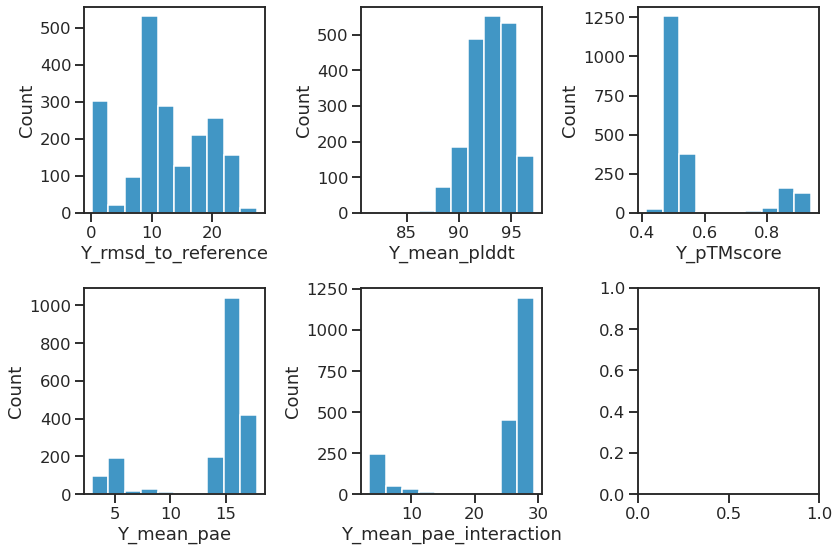

In [13]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "Y_rmsd_to_reference",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_mean_pae",
    "Y_mean_pae_interaction",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    # hue="designed_by",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

<Figure size 1440x1440 with 0 Axes>

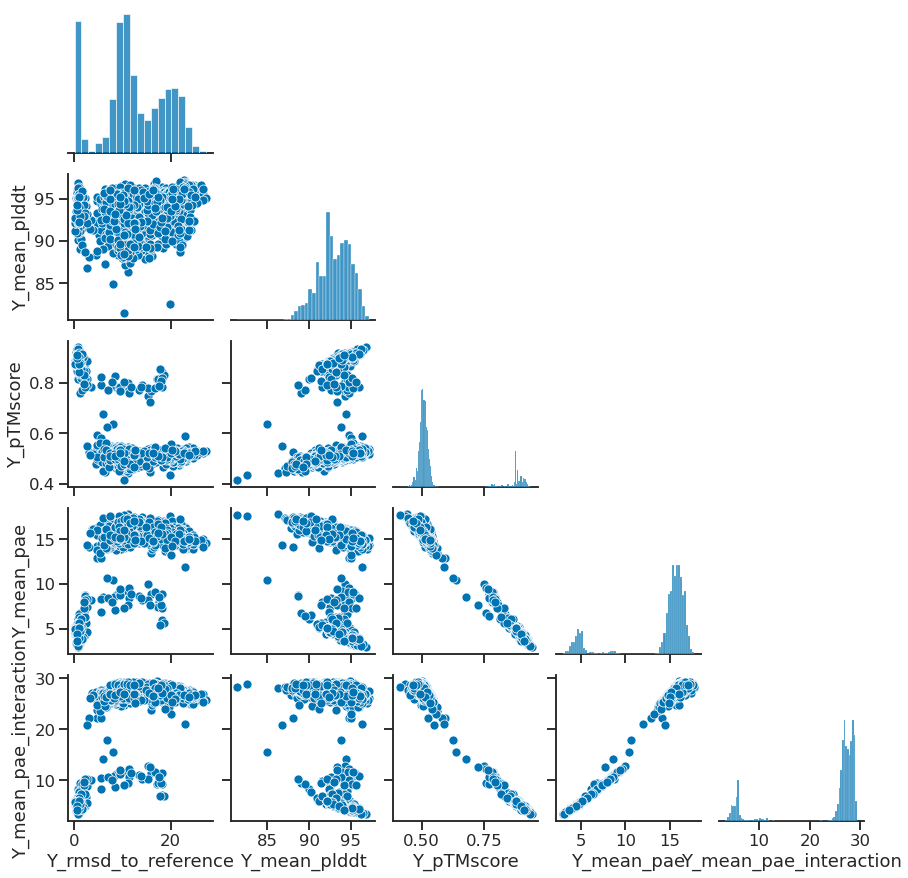

In [14]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    # hue="designed_by",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

### Filter the whole df

In [16]:
query = "Y_mean_plddt > 85 and Y_mean_pae_interaction < 10 and Y_rmsd_to_reference < 3"

filtered = scores_df.query(query)
len(filtered)

5547

In [ ]:
print(list(sorted(set([v for v in filtered.parent.values if len(v) == 5]))))
print(len([v for v in filtered.designed_by.values if v == "rosetta"]))

['DHR20', 'DHR21', 'DHR24', 'DHR26', 'DHR27', 'DHR49', 'DHR52', 'DHR54', 'DHR59', 'DHR70', 'DHR80', 'DHR81', 'DHR82']
59
